### Imports


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import KNNImputer

from scipy.stats import spearmanr
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.decomposition import PCA


### Data Collection


In [78]:
# Load the dataset
file_path = "data/insurance.csv"  # Update the file path if needed
df = pd.read_csv(file_path)

### Data Preprocessing

1. Explore the data


In [79]:

# Step 1: Exploring the dataset
print("Initial Data Info:")
df.info()
print("\nMissing Values:")
print(df.isnull().sum())
print("\nSummary Statistics:")
print(df.describe())
print("\nUnique Values in Categorical Columns:")
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(f"{col}: {df[col].nunique()} unique values")



Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382154 entries, 0 to 382153
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    382154 non-null  int64  
 1   Gender                382154 non-null  object 
 2   Age                   382144 non-null  float64
 3   Driving_License       382154 non-null  int64  
 4   Region_Code           382154 non-null  float64
 5   Previously_Insured    382154 non-null  int64  
 6   Vehicle_Age           382154 non-null  object 
 7   Vehicle_Damage        382151 non-null  object 
 8   Annual_Premium        382154 non-null  float64
 9   Policy_Sales_Channel  382154 non-null  float64
 10  Vintage               382154 non-null  int64  
 11  Response              382154 non-null  int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 35.0+ MB

Missing Values:
id                       0
Gender                   0
Age     

2. Handle Missing Data and Naive Feature Removal



Missing Values:
id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Data after dropping Driving_License:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382154 entries, 0 to 382153
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    382154 non-null  int64  
 1   Gender                382154 non-null  object 
 2   Age                   382154 non-null  float64
 3   Region_Code           382154 non-null  float64
 4   Previously_Insured    382154 non-null  int64  
 5   Vehicle_Age           382154 non-null  object 
 6   Vehicle_Damage        382154 non-null  object 
 7   Annual_Premium        382154 non-nul

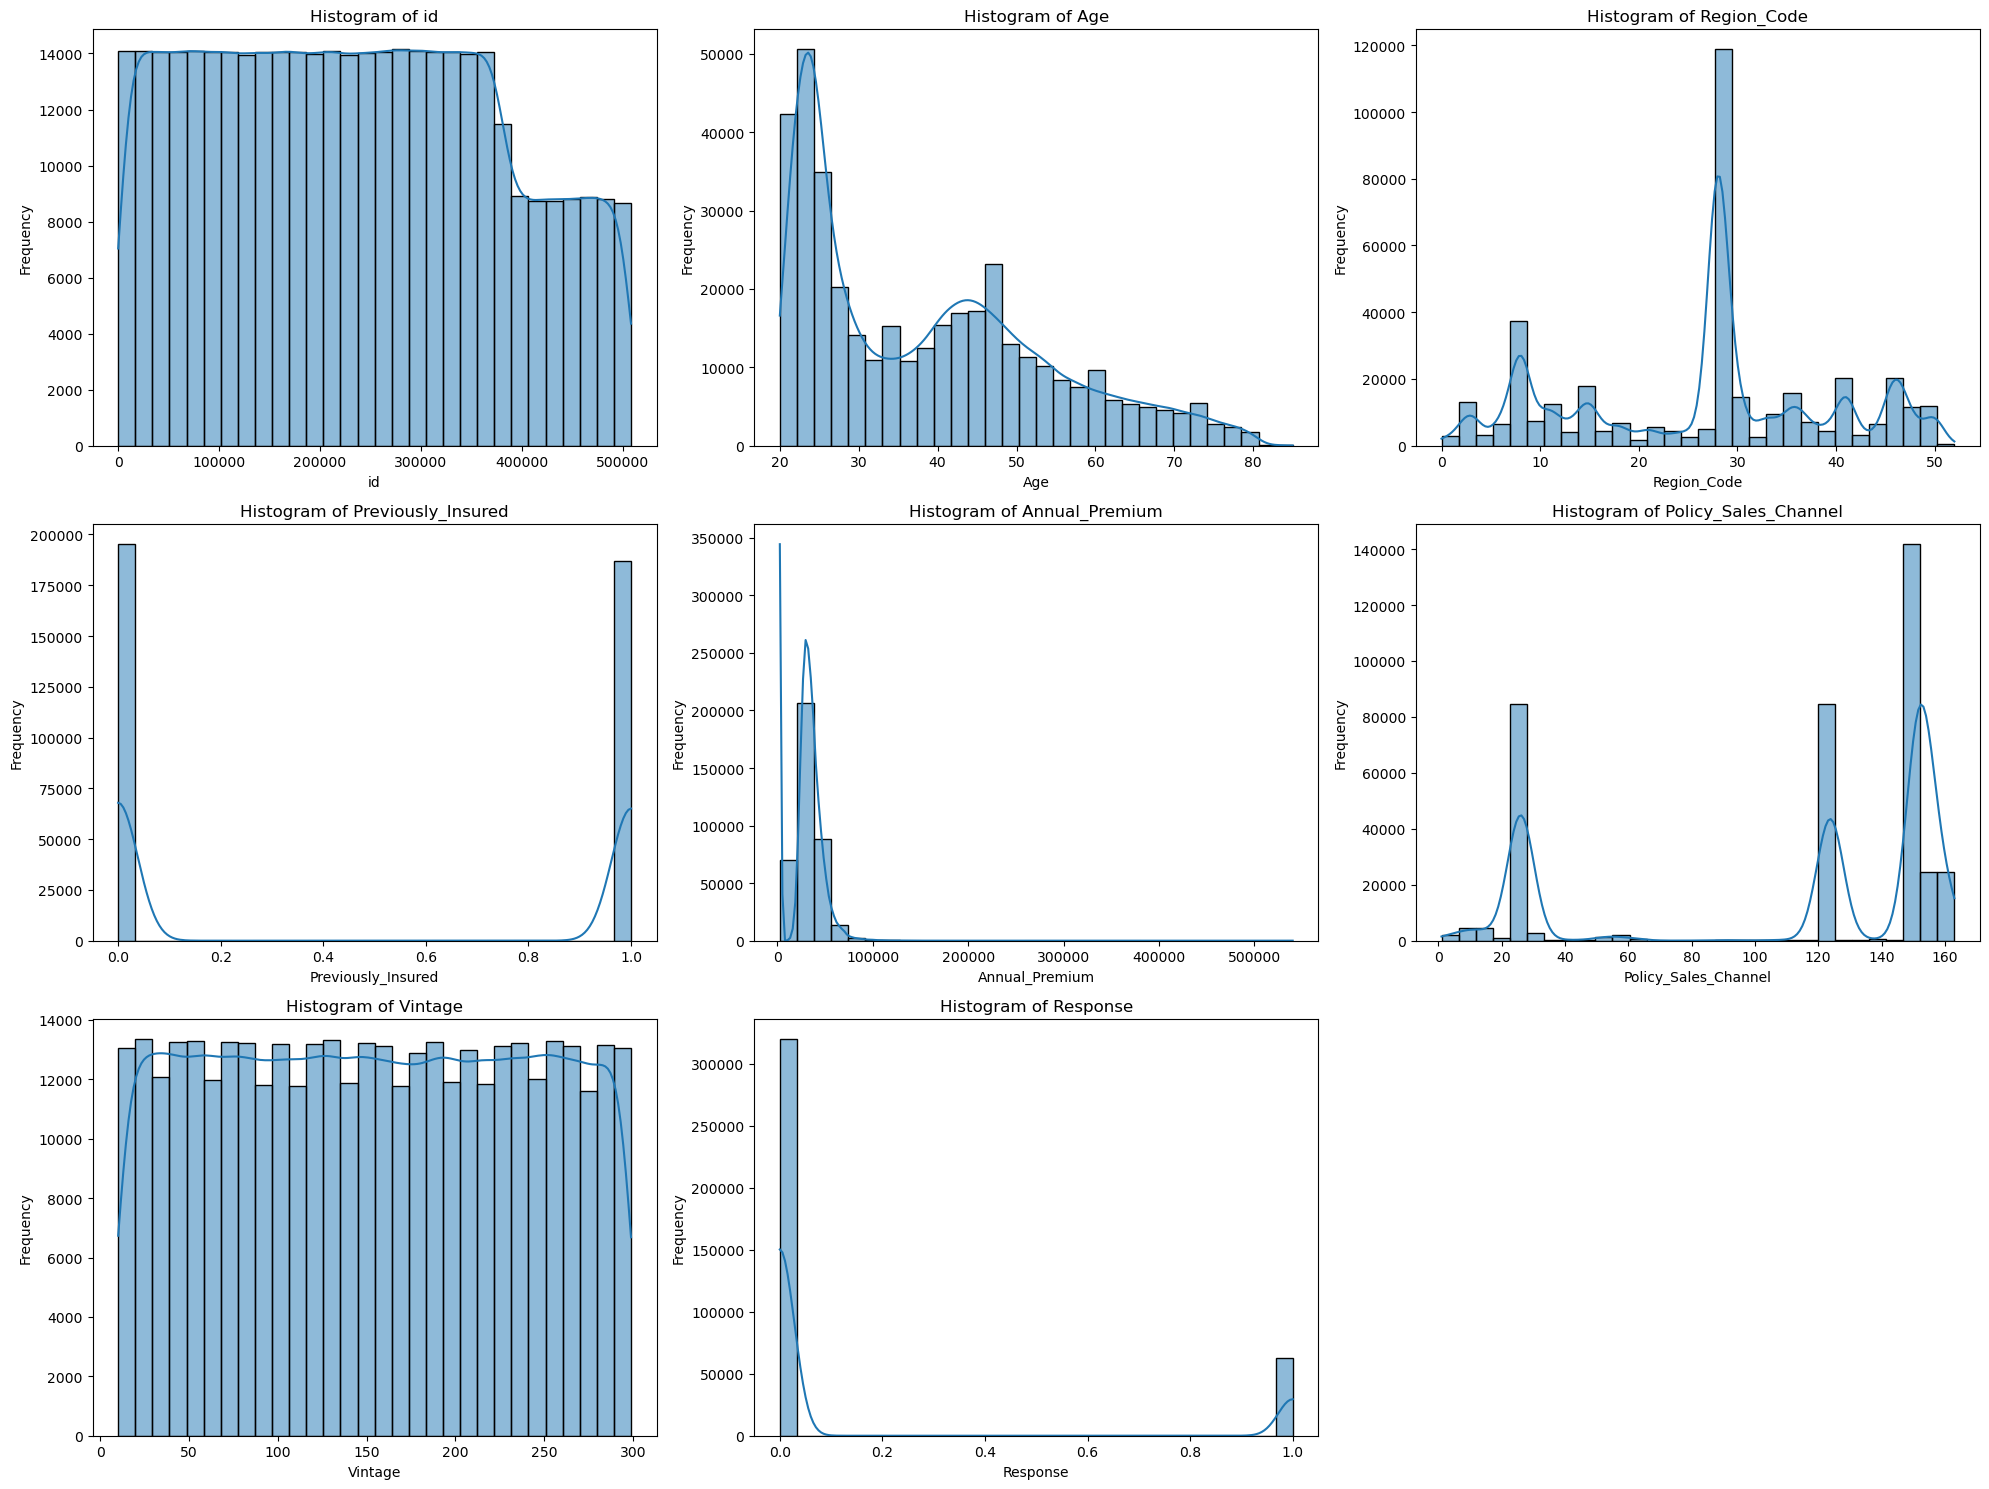

In [ ]:
# Step 2: Handle Missing Values
# Fill missing Age with the median
#df['Age'].fillna(df['Age'].median(), inplace=True)

# Select numerical features for KNN imputation
num_features = ['Age', 'Annual_Premium', 'Vintage']

knn_imputer = KNNImputer(n_neighbors=3)
df[num_features] = knn_imputer.fit_transform(df[num_features])

# Fill missing Vehicle_Damage with the mode (most common value)
#df['Vehicle_Damage'].fillna(df['Vehicle_Damage'].mode()[0], inplace=True)

# Fill missing Vehicle_Damage with a new category 'Unknown'
df['Vehicle_Damage'] = df['Vehicle_Damage'].fillna('Unknown')

print("\nMissing Values:")
print(df.isnull().sum())

# Drop Driving_License column
df.drop(columns=['Driving_License'], inplace=True)

# Verify its gone
print("\nData after dropping Driving_License:")
print(df.info())

# Select only numeric columns
numeric_cols = df.select_dtypes(include='number').columns

# Set up the figure size and layout
plt.figure(figsize=(20, 15))
n_cols = 3  # Number of histograms per row

for i, col in enumerate(numeric_cols, 1):
    plt.subplot((len(numeric_cols) + n_cols - 1) // n_cols, n_cols, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [81]:
# Step 3: Encoding Categorical Variables
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoders for reference



In [82]:
# Step 4: Feature Scaling
scaler = StandardScaler()
numerical_features = ['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
df[numerical_features] = scaler.fit_transform(df[numerical_features])




Target Variable Distribution:
Response
0    319553
1     62601
Name: count, dtype: int64


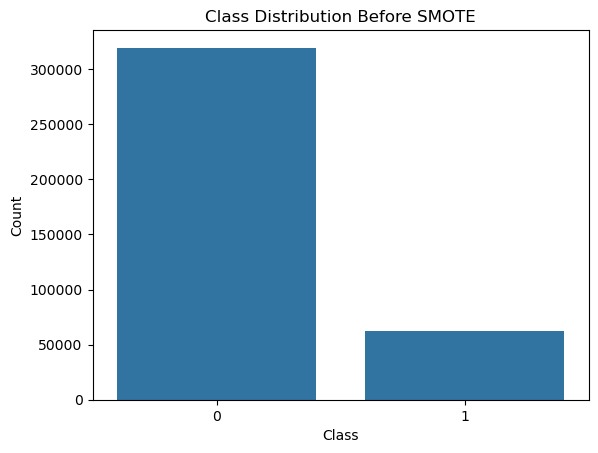

/opt/anaconda3/envs/CSB320x/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Balanced Target Variable Distribution After SMOTE:
Response
0    319553
1    319553
Name: count, dtype: int64


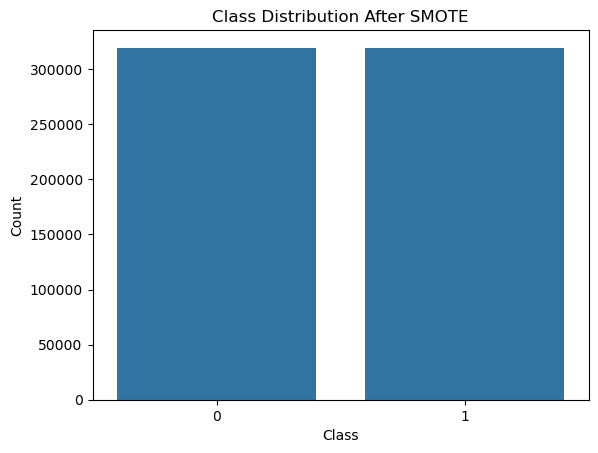

In [83]:
# Step 5: Handling Imbalanced Data using SMOTE
target_column = 'Response'
print("\nTarget Variable Distribution:")
print(df[target_column].value_counts())

X = df.drop(columns=['id', target_column])  # Dropping ID column
y = df[target_column]

# Visualize class distribution before SMOTE
sns.countplot(x=y)
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled[target_column] = y_resampled

print("\nBalanced Target Variable Distribution After SMOTE:")
print(df_resampled[target_column].value_counts())

sns.countplot(x=y_resampled)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()



In [84]:
from scipy.stats import shapiro

# One-liner: Shapiro-Wilk test across all numeric columns
print({col: shapiro(df[col].dropna()).pvalue for col in df.select_dtypes(include='number').columns})

# Step 1: Run Shapiro-Wilk test on all numeric columns
pvalues = {col: shapiro(df[col].dropna()).pvalue for col in df.select_dtypes(include='number').columns}

# Step 2: Separate into normal and not normal
normal_columns = [col for col, p in pvalues.items() if p > 0.05]
not_normal_columns = [col for col, p in pvalues.items() if p <= 0.05]

# Step 3: Print results
print("\nNormally Distributed Columns:")
print(normal_columns)

print("\nNot Normally Distributed Columns:")
print(not_normal_columns)

/opt/anaconda3/envs/CSB320x/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 382154.
  res = hypotest_fun_out(*samples, **kwds)
/opt/anaconda3/envs/CSB320x/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 382154.
  res = hypotest_fun_out(*samples, **kwds)


{'id': 2.212921244890249e-109, 'Gender': 2.061272467222933e-182, 'Age': 7.25173395114305e-136, 'Region_Code': 3.0367096336997545e-123, 'Previously_Insured': 3.17905279788542e-182, 'Vehicle_Age': 5.23497105773462e-174, 'Vehicle_Damage': 2.9232619747472504e-182, 'Annual_Premium': 4.428705273617514e-146, 'Policy_Sales_Channel': 3.881741088581396e-173, 'Vintage': 6.198153161097459e-116, 'Response': 1.6965818473972245e-197}

Normally Distributed Columns:
[]

Not Normally Distributed Columns:
['id', 'Gender', 'Age', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response']


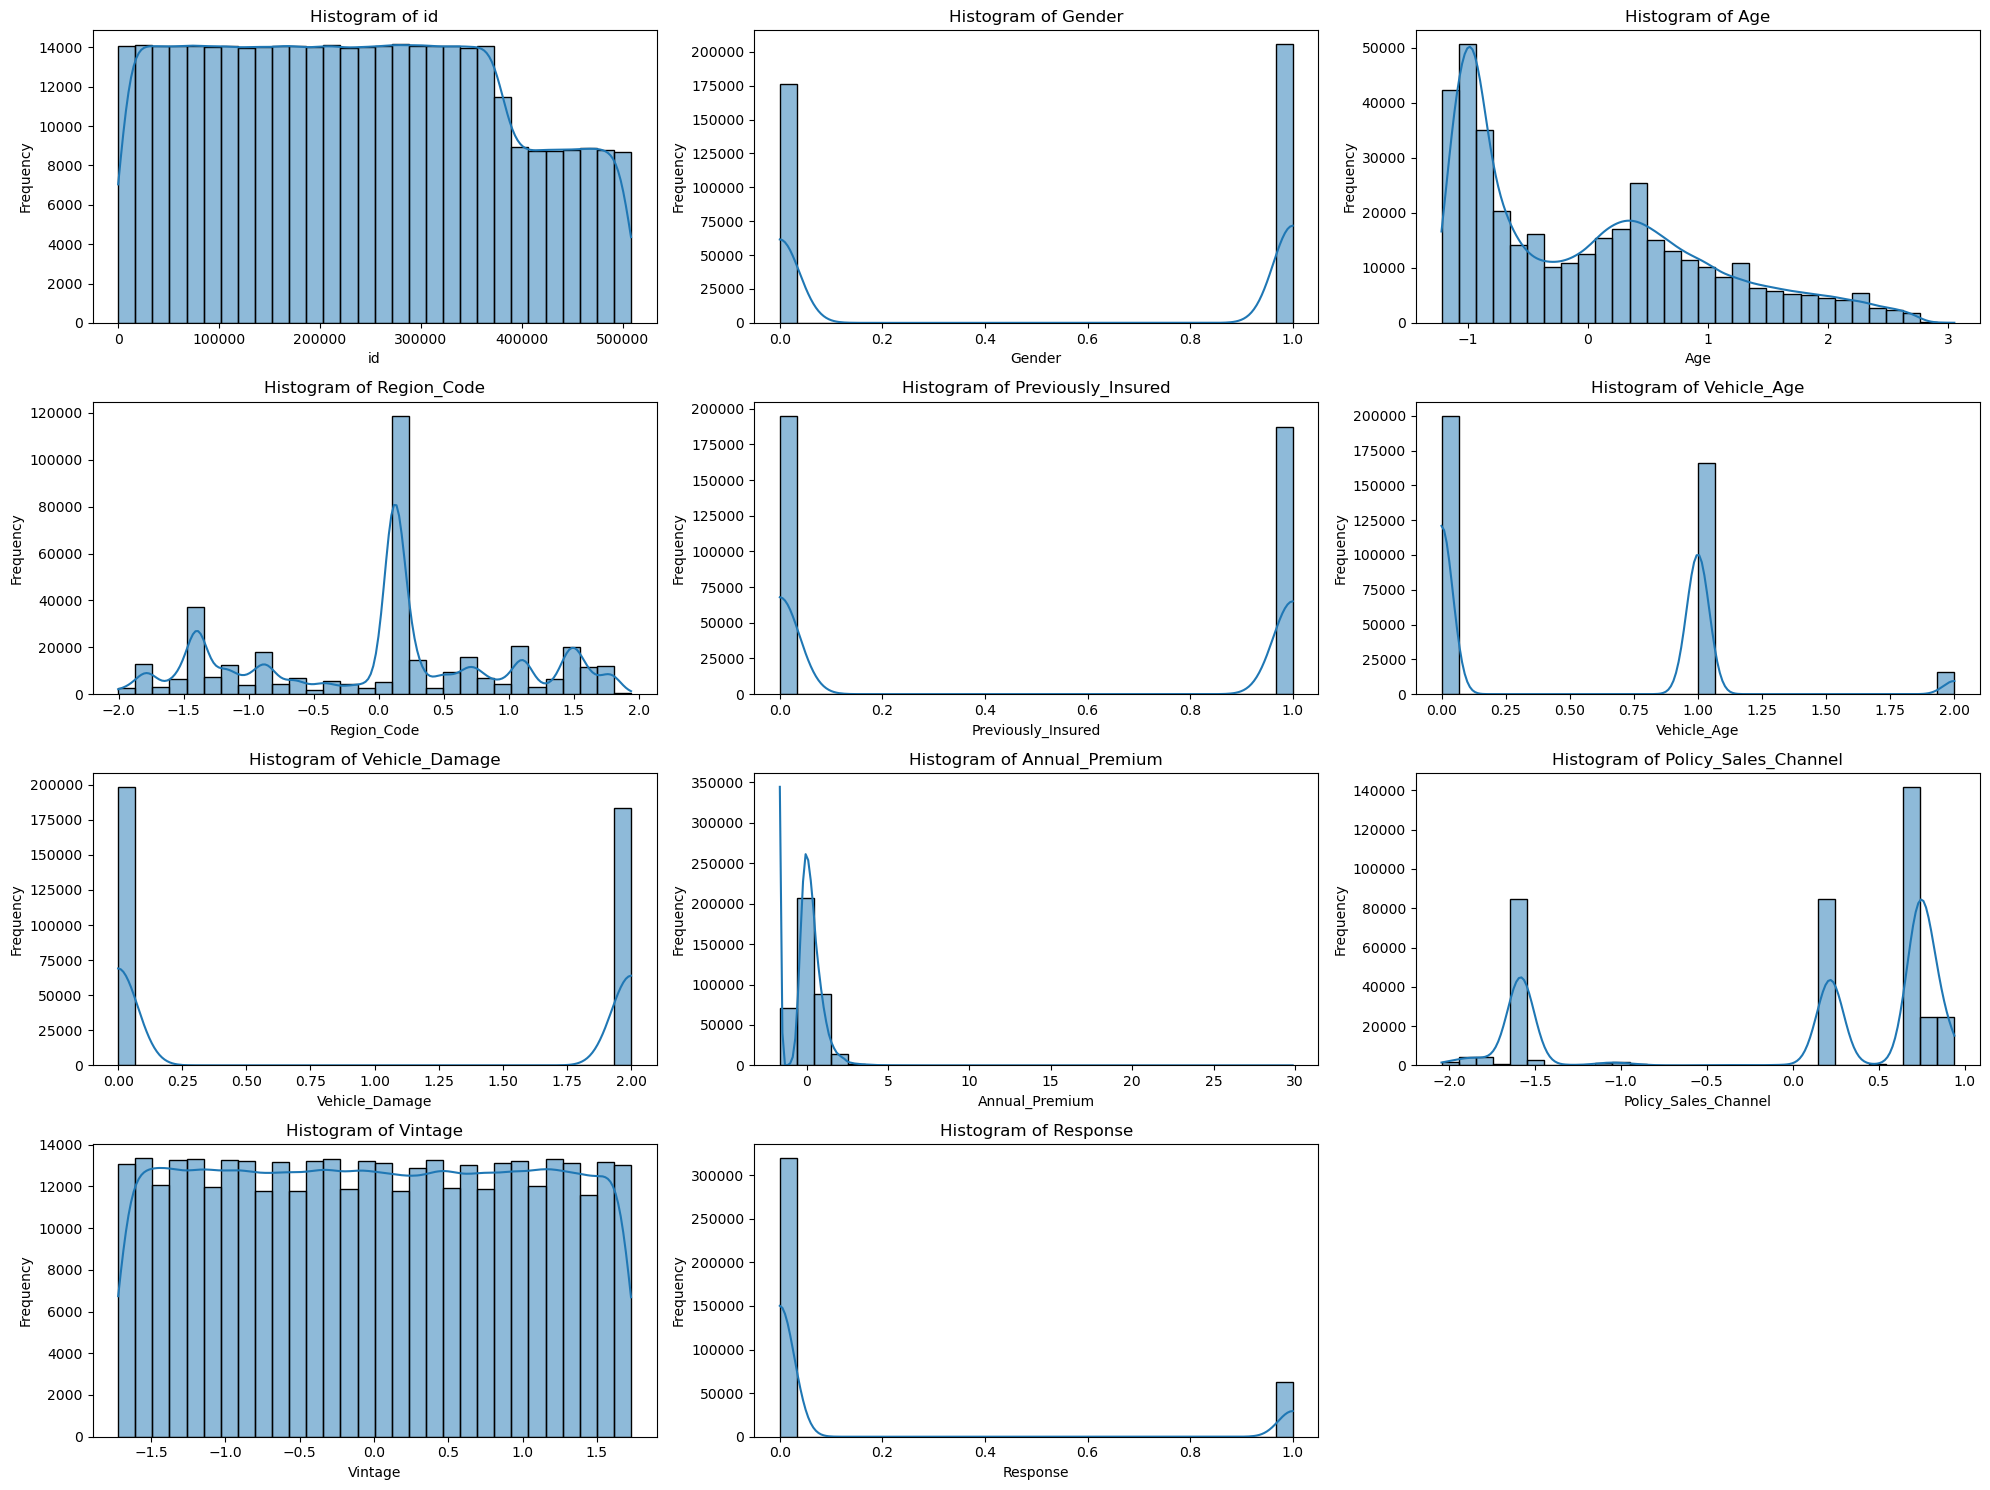

In [85]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include='number').columns

# Set up the figure size and layout
plt.figure(figsize=(20, 15))
n_cols = 3  # Number of histograms per row

for i, col in enumerate(numeric_cols, 1):
    plt.subplot((len(numeric_cols) + n_cols - 1) // n_cols, n_cols, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [86]:
print(X.dtypes)


Gender                    int64
Age                     float64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age               int64
Vehicle_Damage            int64
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                 float64
dtype: object



Ranked Features Based on Association Strength (higher is better):
Vehicle_Damage: 0.4487
Previously_Insured: 0.4312
Vehicle_Age: 0.1891
Age: 0.1840
Policy_Sales_Channel: 0.1803
id: 0.1584
Gender: 0.0669
Annual_Premium: 0.0476
Vintage: 0.0019
Region_Code: 0.0016


/var/folders/93/rj9t3b_11_j6nqvfy9hmfy_80000gn/T/ipykernel_15707/4142170905.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Score', y='Feature', data=scores_df, palette='viridis')


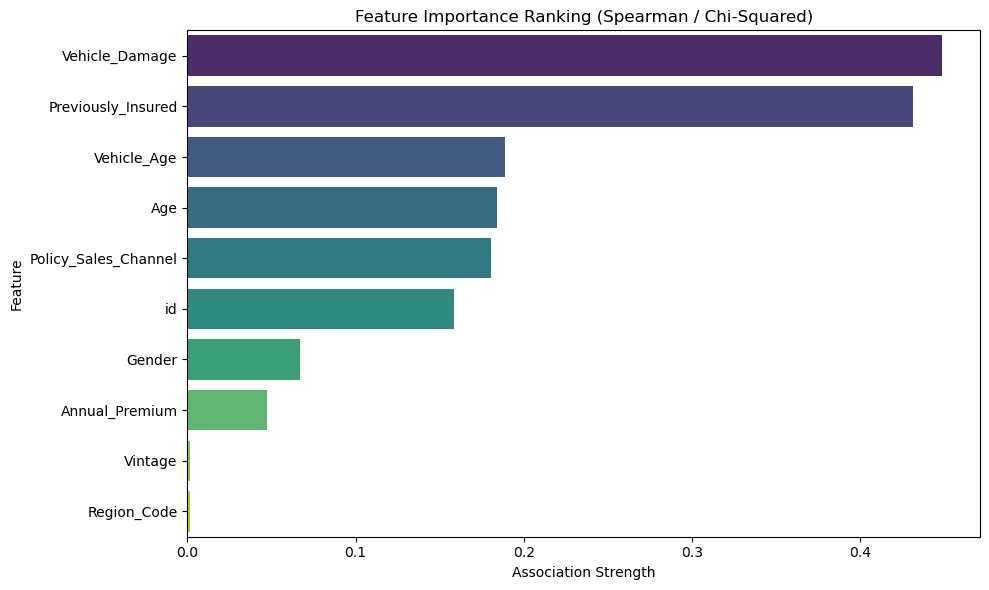

In [87]:
# Assume df is already loaded
target_col = 'Response'
X = df.drop(columns=[target_col])
y = df[target_col]

# Separate features
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()

# 1. Spearman correlation for numeric features
spearman_scores = {}
for col in numeric_cols:
    coef, p = spearmanr(X[col], y)
    spearman_scores[col] = abs(coef)  # Use absolute value

# 2. Chi-Squared test for categorical features (only if they exist)
chi2_results = {}

if categorical_cols:  # Safe check
    X_encoded = X.copy()
    
    # Encode categorical features
    for col in categorical_cols:
        X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col])

    # Normalize numeric features (required for Chi2)
    scaler = MinMaxScaler()
    X_encoded[numeric_cols] = scaler.fit_transform(X_encoded[numeric_cols])

    # Run Chi2
    chi2_scores, chi2_p = chi2(X_encoded[categorical_cols], y)
    chi2_results = dict(zip(categorical_cols, chi2_scores))

# 3. Combine Spearman and Chi2 results
feature_scores = {**spearman_scores, **chi2_results}

# 4. Sort features
sorted_features = sorted(feature_scores.items(), key=lambda item: item[1], reverse=True)

# 5. Print results
print("\nRanked Features Based on Association Strength (higher is better):")
for feature, score in sorted_features:
    print(f"{feature}: {score:.4f}")


# 6. Create a chart
# Convert to DataFrame for easy plotting
scores_df = pd.DataFrame(sorted_features, columns=['Feature', 'Score'])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Feature', data=scores_df, palette='viridis')
plt.title('Feature Importance Ranking (Spearman / Chi-Squared)')
plt.xlabel('Association Strength')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

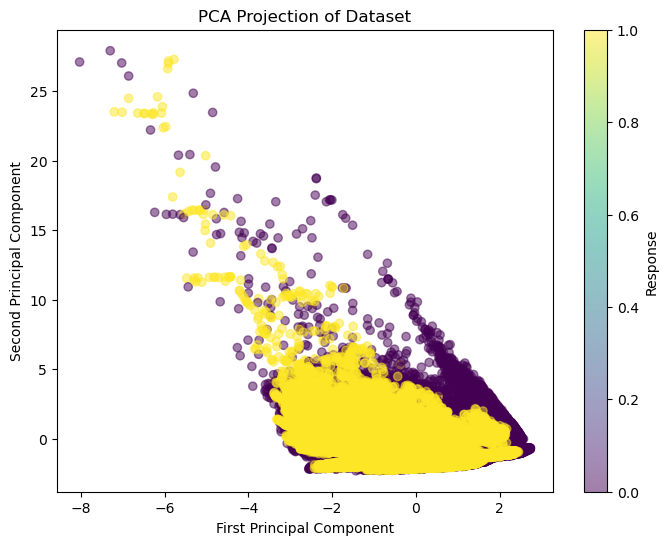

In [89]:
# PCA
# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
X_pca = pca.fit_transform(X_resampled)

# Visualize PCA
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_resampled, cmap='viridis', alpha=0.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Projection of Dataset')
plt.colorbar(label='Response')
plt.show()


In [91]:
# Step 6: Model Training and Evaluation with Naive Bayes
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

print("\nModel Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Model Accuracy: 0.8169798626214579

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.65      0.78     63772
           1       0.74      0.99      0.84     64050

    accuracy                           0.82    127822
   macro avg       0.86      0.82      0.81    127822
weighted avg       0.86      0.82      0.81    127822

